Demo - Poisson's equation 1D
=======================

In this demo we will solve Poisson's equation
    
\begin{align}
\label{eq:poisson}
\nabla^2 u(x) &= f(x), \quad \forall \, x \in [-1, 1]\\
u(\pm 1) &= 0, 
\end{align}

where $u(x)$ is the solution and $f(x)$ is some given function of $x$.

We want to solve this equation with the spectral Galerkin method, using a basis composed of either Chebyshev $T_k(x)$ or Legendre $L_k(x)$ polynomials. Using $P_k$ to refer to either one, Shen's composite basis is then given as 

$$
V^N = \text{span}\{P_k - P_{k+2}\, | \, k=0, 1, \ldots, N-3\},
$$

where all basis functions satisfy the homogeneous boundary conditions.

For the spectral Galerkin method we will also need the weighted inner product

$$
 (u, v)_w = \int_{-1}^1 u v w \, {dx},
$$

where $w(x)$ is a weight associated with the chosen basis, and $v$ and $u$ are test and trial functions, respectively. For Legendre the weight is simply $w(x)=1$, whereas for Chebyshev it is $w(x)=1/\sqrt{1-x^2}$. Quadrature is used to approximate the integral

$$
\int_{-1}^1 u v w \, {dx} \approx \sum_{i=0}^{N-1} u(x_i) v(x_i) \omega_i,
$$

where $\{\omega_i\}_{i=0}^{N-1}$ are the quadrature weights associated with the chosen basis and quadrature rule. The associated quadrature points are denoted as $\{x_i\}_{i=0}^{N-1}$. For Chebyshev we can choose between `Chebyshev-Gauss` or `Chebyshev-Gauss-Lobatto`, whereas for Legendre the choices are `Legendre-Gauss` or `Legendre-Gauss-Lobatto`. 

With the weighted inner product in place we can create variational problems from the original PDE by multiplying with a test function $v$ and integrating over the domain. For a Legendre basis we can use integration by parts and formulate the variational problem: 

Find $u \in V^N$ such that

$$     (\nabla u, \nabla v) = -(f, v), \quad \forall \, v \in V^N.$$

For a Chebyshev basis the integration by parts is complicated due to the non-constant weight and the variational problem used is instead: 

Find $u \in V^N$ such that

$$     (\nabla^2 u, v)_w = (f, v)_w, \quad \forall \, v \in V^N.$$

We now break the problem down to linear algebra. With any choice of basis or quadrature rule we use $\phi_k(x)$ to represent the test function $v$ and thus

$$
\begin{align}
v(x) &= \phi_k(x), \\
u(x) &= \sum_{j=0}^{N-3} \hat{u}_j \phi_j(x),
\end{align}
$$
where $\hat{\mathbf{u}}=\{\hat{u}_j\}_{j=0}^{N-3}$ are the unknown expansion coefficients, also called the degrees of freedom.

Insert into the variational problem for Legendre and we get the linear algebra system to solve for $\hat{\mathbf{u}}$

$$
\begin{align}
(\nabla \sum_{j=0}^{N-3} \hat{u}_j \phi_j, \nabla \phi_k) &= -(f, \phi_k), \\
\sum_{j=0}^{N-3} \underbrace{(\nabla \phi_j, \nabla \phi_k)}_{a_{kj}} \hat{u}_j  &= -\underbrace{(f, \phi_k)}_{\tilde{f}_k}, \\
A \hat{\textbf{u}} &= -\tilde{\textbf{f}},
\end{align}
$$

where $A = (a_{kj})_{0 \ge k, j \ge N-3}$ is the stiffness matrix and $\tilde{\textbf{f}} = \{\tilde{f}_k\}_{k=0}^{N-3}$.


## Implementation with shenfun

The given problem may be easily solved with a few lines of code using the shenfun Python module. The high-level code matches closely the mathematics and the stiffness matrix is assembled simply as

In [1]:
from shenfun import *
import matplotlib.pyplot as plt

N = 100
V = Basis(N, 'Legendre', quad='LG', bc=(0, 0))
v = TestFunction(V)
u = TrialFunction(V)
A = inner(grad(u), grad(v))


Using a manufactured solution that satisfies the boundary conditions we can create just about any corresponding right hand side $f(x)$

In [2]:
import sympy
x = sympy.symbols('x')
ue = (1-x**2)*(sympy.cos(4*x)*sympy.sin(6*x))
fe = ue.diff(x, 2)

Note that `fe` is the right hand side that corresponds to the exact solution `ue`. We now want to use `fe` to compute a numerical solution $u$ that can be compared directly with the given `ue`. First, to compute the inner product $(f, v)$, we need to evaluate `fe` on the quadrature mesh

In [3]:
fl = sympy.lambdify(x, fe, 'numpy')
ul = sympy.lambdify(x, ue, 'numpy')
fj = Array(V, buffer=fl(V.mesh()))

`fj` holds the analytical `fe` on the nodes of the quadrature mesh.
Assemble right hand side $\tilde{\textbf{f}} = -(f, v)_w$ using the shenfun function `inner`

In [4]:
f_tilde = inner(-fj, v)

All that remains is to solve the linear algebra system 

$$
\begin{align}
A \hat{\textbf{u}} &= \tilde{\textbf{f}} \\
\hat{\textbf{u}} &= A^{-1} \tilde{\textbf{f}} 
\end{align}
$$

In [5]:
u_hat = Function(V)
u_hat = A/f_tilde


Get solution in real space, i.e., evaluate $u(x_i) = \sum_{j=0}^{N-3} \hat{u}_j \phi_j(x_i)$ for all quadrature points $\{x_i\}_{i=0}^{N-1}$.

In [6]:
uj = u_hat.backward()

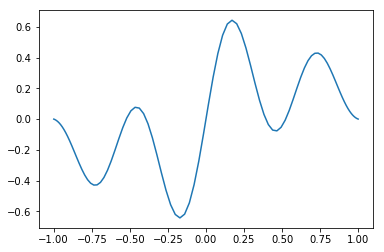

In [7]:
X = V.mesh()
plt.plot(X, uj)